In [62]:
#Imports
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable


###############################################################################

def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))
            
    return loss.item()

import time
def train_many_epochs(model, epochs = 10): 
    lr = 0.1
    start = time.time()
    loss_ot = []
    acc_ot = []
    for epoch in range(epochs):
      optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
      loss = train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
      acc = test(model, device, test_set_loader)
      loss_ot.append(loss)
      acc_ot.append(acc)
      lr = lr/2.0
    end = time.time()
    total_time = end - start
    print(total_time)
    return loss_ot, acc_ot, total_time

def test(model, device, test_set_loader):
    # This method is derived from: 
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size 
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
    return 100. * correct / len(test_set_loader.dataset)

def download_CIFAR10(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.CIFAR10(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.CIFAR10(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

###############################################################################

batch_size = 1000
DATA_PATH = './data'

training_set, testing_set = download_CIFAR10(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

###############################################################################

# Use GPU whever possible!
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

###############################################################################

class SpikingNeuronLayerRNN(nn.Module):
    
    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold
        
        self.fc = nn.Linear(n_inputs, n_hidden)
        
        self.init_parameters()
        self.reset_state()
        self.to(self.device)
        
    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
        
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.
        
        x: activated_neurons_below
        
        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such 
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)
        
        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        
        # 3. We compute the activation of the neuron to find its output value, 
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)
        
        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state 
        #    (and with an extra penalty for increase refractory time), 
        #    because it discharges naturally so it shouldn't fire twice. 
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate
        
        # 5. The outer excitation has a negative part after the positive part. 
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0
        
        # 6. Setting internal values before returning. 
        #    And the returning value is the one of the previous time step to delay 
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
    
###############################################################################
        
class InputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device
        
        self.reset_state()
        self.to(self.device)
        
    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass
    
    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x
    
###############################################################################

class OutputDataToSpikingPerceptronLayer(nn.Module):
    
    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)
    
    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)
    
###############################################################################
        
class SpikingNet(nn.Module):
    
    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=3*32*32, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)
            
            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

###############################################################################


class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(3* 32* 32, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# Replicate original experiment on CIFAR10

###############################################################################
num_epoch = 10

time_step_list = [128,128/2,128/4,128/8,128/16,128/32]
total_time_models = []

fig, ax_lst = plt.subplots(2, len(time_step_list), sharex=True, sharey='row',figsize=(25,10))

for i,step in enumerate(time_step_list):      
  spiking_model = SpikingNet(device, n_time_steps=int(step), begin_eval=0)
  loss, acc, time_m = train_many_epochs(spiking_model, epochs = num_epoch)
  total_time_models.append(time_m)
  ax_lst[0,i].plot(acc)
  ax_lst[0,i].set_title("Spiking Acc, n time steps = %d"%int(step))
  ax_lst[1,i].plot(loss)
  ax_lst[1,i].set_title("Spiking Loss, n time steps = %d"%int(step))

non_spiking_model = NonSpikingNet().to(device)
train_many_epochs(non_spiking_model, epochs = num_epoch)
ax_lst[0,4].plot(acc)
ax_lst[0,4].set_title("NN Acc")
ax_lst[1,4].plot(loss)
ax_lst[1,4].set_title("NN Loss")

plt.figure(figsize=(10,10))
plt.plot(time_step_list, total_time_models)
plt.show()



Train Epoch: 0 [0/50000 (0%)] Loss: 2.482370 Accuracy: 10.20%
Train Epoch: 0 [10000/50000 (20%)] Loss: 2.001025 Accuracy: 27.30%
Train Epoch: 0 [20000/50000 (40%)] Loss: 1.849233 Accuracy: 34.00%
Train Epoch: 0 [30000/50000 (60%)] Loss: 1.781674 Accuracy: 35.40%
Train Epoch: 0 [40000/50000 (80%)] Loss: 1.764423 Accuracy: 36.80%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0017, Accuracy: 3985/10000 (39.85%)

Train Epoch: 1 [0/50000 (0%)] Loss: 1.653718 Accuracy: 40.60%
Train Epoch: 1 [10000/50000 (20%)] Loss: 1.621188 Accuracy: 43.80%
Train Epoch: 1 [20000/50000 (40%)] Loss: 1.602360 Accuracy: 44.90%
Train Epoch: 1 [30000/50000 (60%)] Loss: 1.562517 Accuracy: 44.40%
Train Epoch: 1 [40000/50000 (80%)] Loss: 1.528951 Accuracy: 46.80%

Test set: Average loss: 0.0016, Accuracy: 4365/10000 (43.65%)

Train Epoch: 2 [0/50000 (0%)] Loss: 1.568987 Accuracy: 46.00%
Train Epoch: 2 [10000/50000 (20%)] Loss: 1.602559 Accuracy: 42.60%
Train Epoch: 2 [20000/50000 (40%)] Loss: 1.534873 Accuracy: 47.70%
Train Epoch: 2 [30000/50000 (60%)] Loss: 1.600974 Accuracy: 45.50%
Train Epoch: 2 [40000/50000 (80%)] Loss: 1.505749 Accuracy: 46.50%

Test set: Average loss: 0.0016, Accuracy: 4632/10000 (46.32%)

Train Epoch: 3 [0/50000 (0%)] Loss: 1.450979 Accuracy: 49.50%
Train Epoch: 3 [10000/50000 (20%)] Loss: 1.506519 Accuracy: 50.10%
Train Epoch: 3 [200

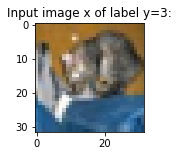

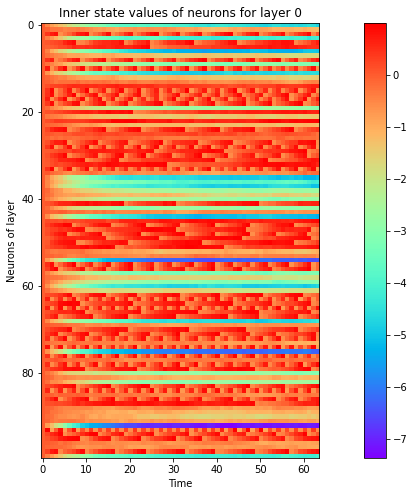

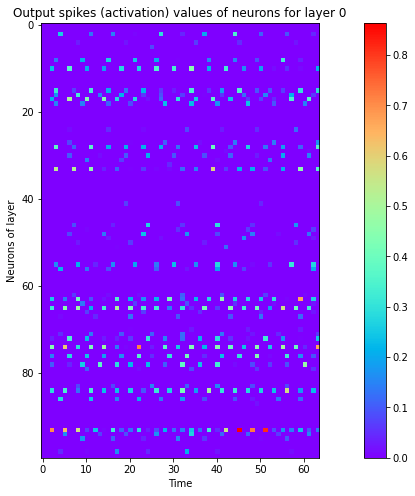

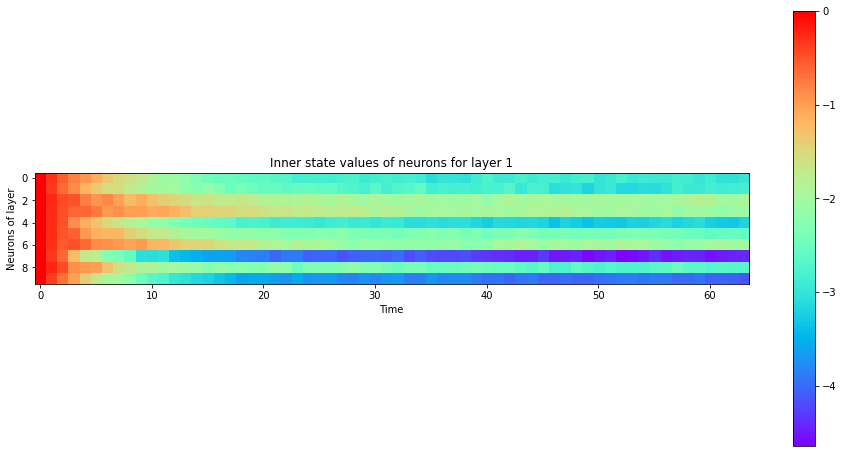

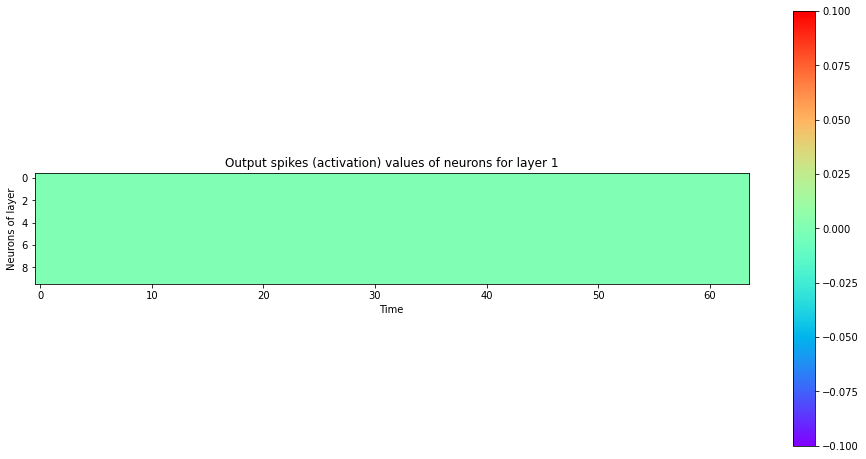

A hidden neuron that looks excited:


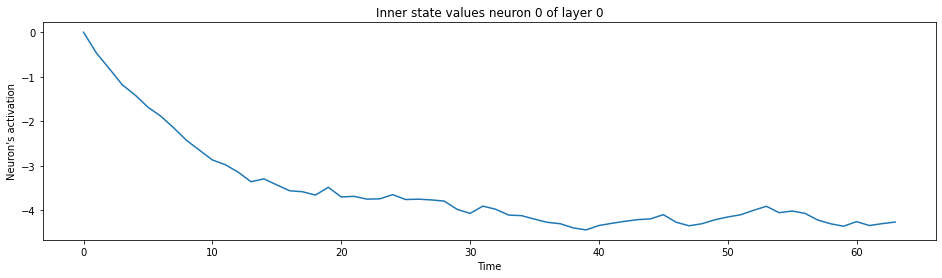

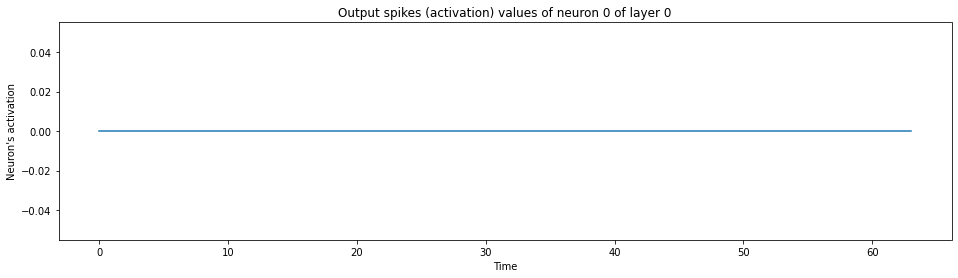

The output neuron of the label:


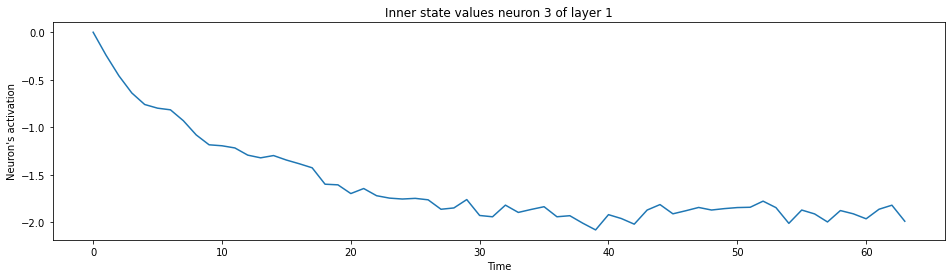

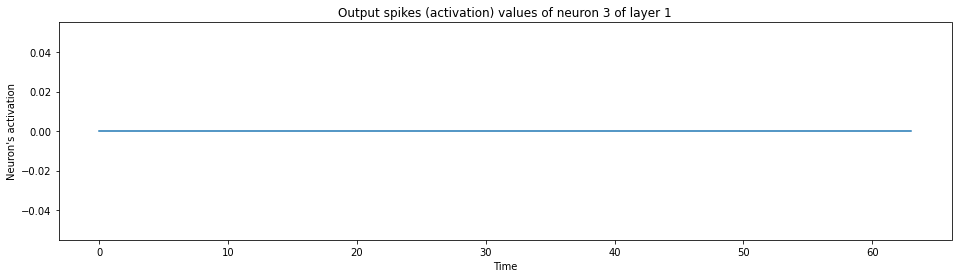

In [22]:
###############################################################################

import numpy as np

data, target = test_set_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]])
y = target.data.numpy()[0]
plt.figure(figsize=(2,2))
plt.imshow(x.data[0].cpu().numpy().transpose(1,2,0)+.5)
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x.to(device))
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x.to(device), layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x.to(device), layer_idx=1, neuron_idx=y)

In [0]:
###############################################################################

class SpikingNet2(nn.Module):

    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet2, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval
        
        self.input_conversion = InputDataToSpikingPerceptronLayer(device)
        
        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=3*32*32, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

        self.layer3 = SpikingNeuronLayerRNN(
            device, n_inputs=10, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )
        
        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.
        
        self.to(self.device)
    
    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return 
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()
        self.layer3.reset_state()

        out = []
        
        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        all_layer3_states = []
        all_layer3_outputs = []

        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
            
            # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)
            
            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)

            layer3_state, layer3_output = self.layer3(layer2_output)


            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            all_layer3_states.append(layer3_state)
            all_layer3_outputs.append(layer3_output)
            out.append(layer3_state)
            
        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs], [all_layer3_states, all_layer3_outputs]]
    
    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()
            
            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))
    
    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from: 
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition 
        Which was released under the MIT License. 
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

###############################################################################


class NonSpikingNet(nn.Module):
    
    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(3* 32* 32, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

In [41]:
###############################################################################
        
spiking_model = SpikingNet2(device, n_time_steps=int(128/2), begin_eval=0)
train_many_epochs(spiking_model, epochs = 2)

non_spiking_model = NonSpikingNet().to(device)
train_many_epochs(non_spiking_model, epochs = 2)

###############################################################################

data, target = test_set_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]])
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)

Train Epoch: 0 [0/50000 (0%)] Loss: 2.606034 Accuracy: 10.60%
Train Epoch: 0 [10000/50000 (20%)] Loss: 2.308818 Accuracy: 9.20%
Train Epoch: 0 [20000/50000 (40%)] Loss: 2.305887 Accuracy: 10.80%
Train Epoch: 0 [30000/50000 (60%)] Loss: 2.308522 Accuracy: 10.10%
Train Epoch: 0 [40000/50000 (80%)] Loss: 2.305258 Accuracy: 9.60%


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0023, Accuracy: 1000/10000 (10.00%)

Train Epoch: 1 [0/50000 (0%)] Loss: 2.306466 Accuracy: 10.00%
Train Epoch: 1 [10000/50000 (20%)] Loss: 2.306579 Accuracy: 9.10%
Train Epoch: 1 [20000/50000 (40%)] Loss: 2.309128 Accuracy: 9.00%
Train Epoch: 1 [30000/50000 (60%)] Loss: 2.306650 Accuracy: 10.10%
Train Epoch: 1 [40000/50000 (80%)] Loss: 2.299398 Accuracy: 13.70%


KeyboardInterrupt: ignored

In [42]:
###############################################################################
        
spiking_model = SpikingNet(device, n_time_steps=int(128), begin_eval=0)
train_many_epochs(spiking_model, epochs = 2)

non_spiking_model = NonSpikingNet().to(device)
train_many_epochs(non_spiking_model, epochs = 2)

###############################################################################

data, target = test_set_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]])
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)

Train Epoch: 0 [0/50000 (0%)] Loss: 2.393840 Accuracy: 8.00%
Train Epoch: 0 [10000/50000 (20%)] Loss: 2.038409 Accuracy: 23.50%


KeyboardInterrupt: ignored